In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import math
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/AIIoT-makerthon'

Mounted at /content/drive


In [3]:
TRAIN_DATA_DIR = path+'/7segdataset_aug_split/train'
VALIDATION_DATA_DIR = path+'/7segdataset_aug_split/val'
TEST_DATA_DIR = path+'/7segdataset_aug_split/test'

NUM_CLASSES = 10
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 16

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 2100 images belonging to 10 classes.
Found 610 images belonging to 10 classes.


In [5]:
train_generator.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [6]:
def model_maker():
    base_model = VGG16(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    print(len(base_model.layers))

    for layer in base_model.layers[:]:
        layer.trainable = False

    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(32, activation='relu')(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)

    return Model(inputs=input, outputs=predictions)

model_final = model_maker()
model_final.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
19


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,731,434 (56.20 MB)

 Trainable params: 16,746 (65.41 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])

In [8]:
history = model_final.fit(
    train_generator,
    steps_per_epoch=len(train_generator), # number of updates
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1145s 9s/step - acc: 0.1036 - loss: 3.1957 - val_acc: 0.1410 - val_loss: 2.3150
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - acc: 0.1244 - loss: 2.2915 - val_acc: 0.1410 - val_loss: 2.2473
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 205ms/step - acc: 0.1632 - loss: 2.2148 - val_acc: 0.2246 - val_loss: 2.1710
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 205ms/step - acc: 0.1984 - loss: 2.1517 - val_acc: 0.2344 - val_loss: 2.0360
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 207ms/step - acc: 0.2438 - loss: 2.0393 - val_acc: 0.2721 - val_loss: 1.9255
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 205ms/step - acc: 0.2948 - loss: 1.8913 - val_acc: 0.2918 - val_loss: 1.8425
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - acc: 0.3206 - loss: 1.8309 - val_acc: 0.3393 - val_loss: 1.7701
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - acc: 0.3395 - loss: 1.7576 - val_acc: 0.3230 - val_loss: 1.8429
Epoch 9/100
132/132 ━━━━━

In [9]:
model_final.save(path+'/7seg_vgg16_model_v1.h5')

result

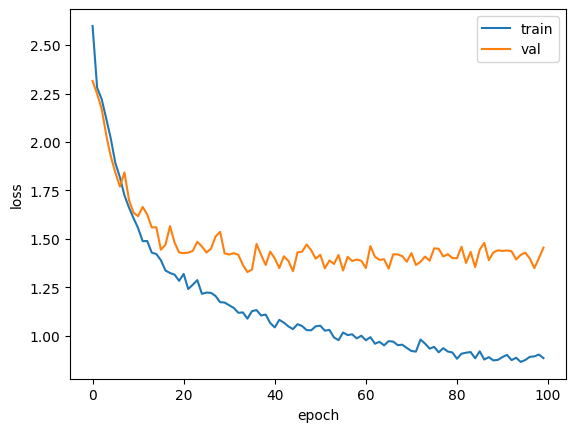

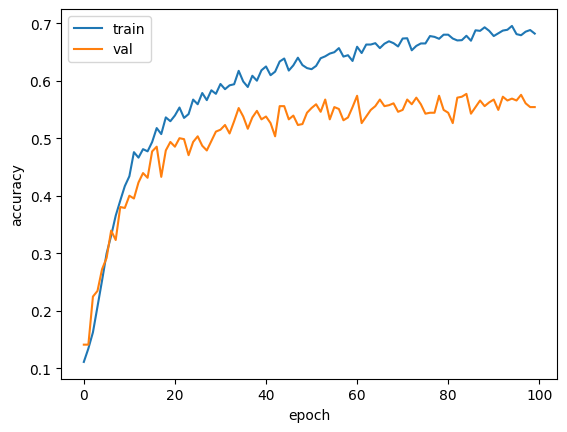

In [10]:
# loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

# accuracy graph
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[0.21077864 0.43716016 0.00444931 0.05790904 0.06998546 0.00923682
 0.06739189 0.05649253 0.06640437 0.0201918 ]


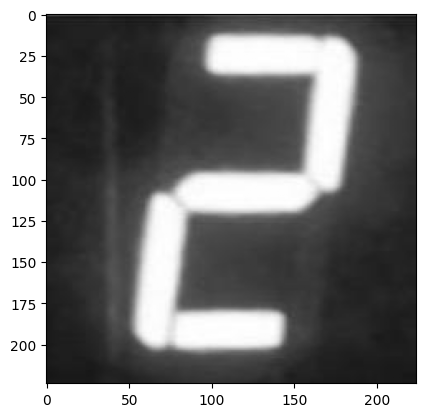

In [15]:
# pred ex
np.set_printoptions(suppress=True)

img_path = path+'/7segdataset_aug_split/test/1/d43f9668-3e0a-4333-9e39-75a5905a27c9.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
plt.imshow(img_array/255)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255

prediction = model_final.predict(preprocessed_img)
print(np.array(prediction[0]))

In [12]:
# test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

model_final.evaluate(test_generator, steps=len(test_generator))

Found 300 images belonging to 10 classes.
19/19 ━━━━━━━━━━━━━━━━━━━━ 118s 7s/step - acc: 0.6157 - loss: 1.2131


[1.3556541204452515, 0.5833333134651184]